In [221]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

Part 2] 1.     The Factors

In [222]:
df = pd.read_excel("/Users/jacopomichelacci/FINM_32500/data/dfa_analysis_data.xlsx", sheet_name="factors", index_col="Date")
rf_col = df["RF"]
df.drop(columns=["RF"], inplace=True)
df.rename(columns={"Mkt-RF" : "MKT"}, inplace=True)

mean_tots = df.mean() * 12
vol_tots = df.std() * (12 ** 0.5)
sharpe_tots = mean_tots / vol_tots
VaR_05_tots = df.quantile(0.05)

date_1980 = "1980-12-31 00:00:00"
date_2001 = "2001-12-31 00:00:00"
date_2002 = "2002-12-31 00:00:00"

subs1 = df.loc[:date_1980]
subs2 = df.loc[date_1980:date_2001]
subs3 = df.loc[date_2002:]

factors = ["MKT", "SMB", "HML"]
subs = [subs1, subs2, subs3]
results = {}

for f in factors:
    mean_list, vol_list, sharpe_list, VaR_list = [], [], [], []

    for sub in subs:
        series = sub[f]
        mean = (series.mean() * 12)
        vol = (series.std() * (12 ** 0.5))
        sharpe = mean / vol
        VaR_05 = (series.quantile(0.05))

        mean_list.append(mean)
        vol_list.append(vol)
        sharpe_list.append(sharpe)
        VaR_list.append(VaR_05)
    
    results[f] = pd.DataFrame({
    "mean" : mean_list,
    "vol" : vol_list,
    "sharpe" : sharpe_list,
    "VaR.05" : VaR_list
    }, index=["<1980", "1981–2001", "2002–End"])


for f, df_factor in results.items():
    print(f"\n{f} results:")
    print(df_factor.round(4))





MKT results:
             mean     vol  sharpe  VaR.05
<1980      0.0810  0.2050  0.3949 -0.0841
1981–2001  0.0754  0.1573  0.4796 -0.0641
2002–End   0.1027  0.1507  0.6816 -0.0761

SMB results:
             mean     vol  sharpe  VaR.05
<1980      0.0339  0.1143  0.2968 -0.0419
1981–2001 -0.0021  0.1170 -0.0183 -0.0457
2002–End   0.0060  0.0866  0.0697 -0.0389

HML results:
             mean     vol  sharpe  VaR.05
<1980      0.0503  0.1342  0.3749 -0.0442
1981–2001  0.0656  0.1098  0.5980 -0.0416
2002–End  -0.0025  0.1070 -0.0235 -0.0415


2] 2.
Market (MKT): positive premium in all subsamples — strongest after 2002.

Size (SMB): premium turns negative after 1980, so yes, it gets smaller (even reverses).

Value (HML): premium declines during the 1990s (1981–2001 still positive but weaker, then negative after 2002).

Since 2002: market stays strong, but size and value factors have lost or reversed their premiums, showing much weaker performance.



2] 3.


In [223]:
corr = df.corr()

print("Full sample: \n", corr.round(4))

for name, sub in zip(["<1980", "1981–2001", "2002–End"], [subs1, subs2, subs3]):
    print(f"\nsample {name} \n", sub.corr().round(4))


Full sample: 
         MKT     SMB     HML
MKT  1.0000  0.3204  0.2278
SMB  0.3204  1.0000  0.1258
HML  0.2278  0.1258  1.0000

sample <1980 
         MKT     SMB     HML
MKT  1.0000  0.3742  0.4423
SMB  0.3742  1.0000  0.3134
HML  0.4423  0.3134  1.0000

sample 1981–2001 
         MKT     SMB     HML
MKT  1.0000  0.1586 -0.5312
SMB  0.1586  1.0000 -0.4452
HML -0.5312 -0.4452  1.0000

sample 2002–End 
         MKT     SMB     HML
MKT  1.0000  0.3523  0.1314
SMB  0.3523  1.0000  0.1002
HML  0.1314  0.1002  1.0000


Overall, the factors are only modestly correlated, meaning the construction method largely succeeds in keeping them distinct. Before 1980, correlations are somewhat higher, suggesting less separation in early data. During 1981–2001, correlations fall sharply—with the market and value factors even turning negative—showing effective diversification. After 2002, correlations stay low, confirming that the factors remain largely independent through time.

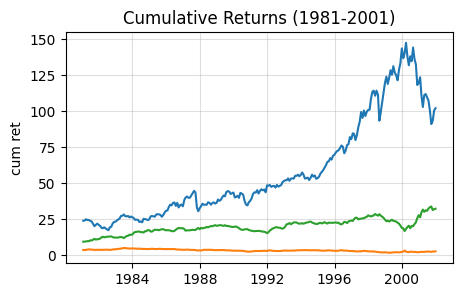

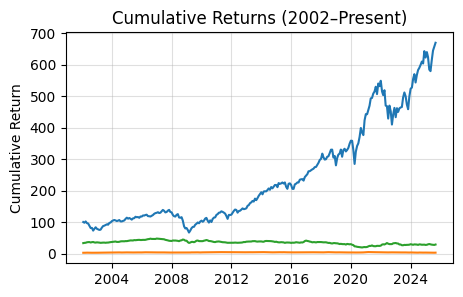

In [224]:
cum_r = (1 + df).cumprod() - 1

#subsamples
cum_81_01 = cum_r.loc["1981":"2001"]
cum_02_end = cum_r.loc["2002":]

plt.figure(figsize=(5,3))
plt.plot(cum_81_01.index, cum_81_01)
plt.title("Cumulative Returns (1981-2001)")
plt.ylabel("cum ret")
plt.grid(alpha=0.4)
plt.show()

#2002-to present plot
plt.figure(figsize=(5,3))
plt.plot(cum_02_end.index, cum_02_end)
plt.title("Cumulative Returns (2002–Present)")
plt.ylabel("Cumulative Return")
plt.grid(alpha=0.4)
plt.show()


Cumulative returns show how much each factor grew over time, but they don’t capture risk. To really judge whether a factor was valuable, we also need to look at the Sharpe ratio, which measures return relative to volatility. Between 1981 and 2001, the market factor performed strongly and had a solid Sharpe ratio, while the value factor also offered good risk-adjusted returns. The size factor, however, added little benefit. After 2001, the market continued to perform well, but both size and value factors weakened, suggesting that DFA should focus more on overall market exposure rather than relying heavily on size or value premiums.

Part 3] 1.

In [225]:
df_port = pd.read_excel("/Users/jacopomichelacci/FINM_32500/data/dfa_analysis_data.xlsx", sheet_name="portfolios (total returns)", index_col="Date")

df_port = df_port.sub(rf_col, axis=0)

#calc of univariate stats for each portfolio
stats = df_port.apply(lambda x: pd.Series({
    "mean" : x.mean() * 12,
    "std" : x.std() * (12 ** 0.5),
    "sharpe" :  (x.mean() * 12) / (x.std() * (12 ** 0.5)),
    "VaR_05" : x.quantile(0.05)
}))

print(stats.round(4))



        SMALL LoBM  ME1 BM2  ME1 BM3  ME1 BM4  SMALL HiBM  ME2 BM1  ME2 BM2  \
mean        0.0683   0.0791   0.1172   0.1351      0.1608   0.0774   0.1110   
std         0.4127   0.3343   0.3064   0.2866      0.3174   0.2760   0.2590   
sharpe      0.1655   0.2367   0.3825   0.4712      0.5065   0.2805   0.4286   
VaR_05     -0.1429  -0.1284  -0.1041  -0.1021     -0.1136  -0.1111  -0.0964   

        ME2 BM3  ME2 BM4  ME2 BM5  ...  ME4 BM1  ME4 BM2  ME4 BM3  ME4 BM4  \
mean     0.1152   0.1242   0.1476  ...   0.0878   0.0931   0.1004   0.1161   
std      0.2500   0.2574   0.3003  ...   0.2144   0.2112   0.2180   0.2361   
sharpe   0.4609   0.4826   0.4916  ...   0.4093   0.4409   0.4607   0.4918   
VaR_05  -0.0930  -0.0938  -0.1125  ...  -0.0883  -0.0863  -0.0853  -0.0905   

        ME4 BM5  BIG LoBM  ME5 BM2  ME5 BM3  ME5 BM4  BIG HiBM  
mean     0.1235    0.0828   0.0780   0.0848   0.0805    0.1149  
std      0.2964    0.1849   0.1819   0.1931   0.2261    0.2928  
sharpe   0.4166   

Part 3] 2.

In [226]:

betas, alphas, maes, R2, treynor, info = [], [], [], [], [], []

mkt = df["MKT"]   # market excess return

for col in df_port.columns:
    y = df_port[col]              # portfolio excess return
    X = np.vstack([np.ones(len(mkt)), mkt]).T  # add constant
    beta_hat = np.linalg.inv(X.T @ X) @ X.T @ y  # OLS coefficients
    alpha, beta = beta_hat

    y_hat = X @ beta_hat
    residuals = y - y_hat
    mae = np.mean(np.abs(residuals))
    r2 = 1 - np.sum(residuals**2) / np.sum((y - y.mean())**2)
    trey = y.mean() / beta
    info_ratio = alpha / residuals.std()

    alphas.append(alpha)
    betas.append(beta)
    maes.append(mae)
    R2.append(r2)
    treynor.append(trey)
    info.append(info_ratio)

# Store results for CAPM analysis
results_capm = {}
residuals_capm = {}

for i, col in enumerate(df_port.columns):
    results_capm[col] = [alphas[i], betas[i]]
    residuals_capm[col] = df_port[col].values - (alphas[i] + betas[i] * mkt.values)

# DataFrame for reporting
results = pd.DataFrame({
    "alpha": alphas,
    "beta": betas,
    "MAE": maes,
    "R²": R2,
    "Treynor": treynor,
    "InfoRatio": info
}, index=df_port.columns)

print(results.round(4))


             alpha    beta     MAE      R²  Treynor  InfoRatio
SMALL LoBM -0.0054  1.6023  0.0482  0.5111   0.0036    -0.0644
ME1 BM2    -0.0030  1.3930  0.0377  0.5888   0.0047    -0.0487
ME1 BM3     0.0004  1.3593  0.0338  0.6671   0.0072     0.0077
ME1 BM4     0.0025  1.2647  0.0301  0.6601   0.0089     0.0525
SMALL HiBM  0.0040  1.3605  0.0344  0.6231   0.0098     0.0713
ME2 BM1    -0.0023  1.2702  0.0296  0.7182   0.0051    -0.0546
ME2 BM2     0.0008  1.2317  0.0239  0.7670   0.0075     0.0209
ME2 BM3     0.0013  1.2006  0.0221  0.7819   0.0080     0.0392
ME2 BM4     0.0020  1.2158  0.0240  0.7565   0.0085     0.0536
ME2 BM5     0.0028  1.3769  0.0313  0.7129   0.0089     0.0604
ME3 BM1    -0.0014  1.2449  0.0223  0.8112   0.0057    -0.0448
ME3 BM2     0.0012  1.1315  0.0180  0.8617   0.0080     0.0507
ME3 BM3     0.0014  1.1199  0.0179  0.8492   0.0082     0.0565
ME3 BM4     0.0019  1.1709  0.0206  0.8068   0.0085     0.0625
ME3 BM5     0.0017  1.3568  0.0292  0.7427   0.0081    

In [227]:
x = results["beta"].values        # betas from your CAPM table
y = df_port.mean().values * 12    # annualized mean excess returns

X = np.vstack([np.ones(len(x)), x]).T
gamma_hat = np.linalg.inv(X.T @ X) @ X.T @ y
gamma0, gammaM = gamma_hat

y_hat = X @ gamma_hat
resid = y - y_hat
R2 = 1 - np.sum(resid**2) / np.sum((y - y.mean())**2)

print("Intercept (γ₀):", gamma0.round(4))
print("Slope (γM):", gammaM.round(4))
print("R²:", R2.round(4))


Intercept (γ₀): 0.048
Slope (γM): 0.0478
R²: 0.0975


These results do not support CAPM.
Since many portfolios (especially small and high book-to-market ones) earn higher returns than their betas predict, this supports DFA’s belief that size (SMB) and value (HML) factors capture premia beyond the market factor.

Part 4] 1.

In [228]:
# === 1. Compute tangency portfolio weights ===
mu = df_port.mean().values           # mean excess returns (monthly)
Sigma = np.cov(df_port.T)            # covariance matrix
inv_Sigma = np.linalg.inv(Sigma)
w_tan = inv_Sigma @ mu
w_tan /= np.sum(w_tan)               # normalize weights

# === 2. Build tangency factor time series ===
tangency_factor = df_port.values @ w_tan
df_tan = pd.Series(tangency_factor, index=df_port.index, name="Tangency")

# === 3. Run time-series regressions (like CAPM but with tangency portfolio factor) ===
alphas, betas, maes, R2 = [], [], [], []

for col in df_port.columns:
    y = df_port[col].values
    X = np.vstack([np.ones(len(df_tan)), df_tan]).T
    beta_hat = np.linalg.inv(X.T @ X) @ X.T @ y
    alpha, beta = beta_hat

    y_hat = X @ beta_hat
    resid = y - y_hat
    mae = np.mean(np.abs(resid))
    r2 = 1 - np.sum(resid**2) / np.sum((y - y.mean())**2)

    alphas.append(alpha)
    betas.append(beta)
    maes.append(mae)
    R2.append(r2)

results_tan = pd.DataFrame({
    "alpha": alphas,
    "beta": betas,
    "MAE": maes,
    "R²": R2
}, index=df_port.columns)

print("\n=== Tangency-Factor Regressions ===")
print(results_tan.round(4))



=== Tangency-Factor Regressions ===
            alpha    beta     MAE      R²
SMALL LoBM   -0.0  0.2443  0.0715  0.0256
ME1 BM2       0.0  0.2831  0.0595  0.0524
ME1 BM3       0.0  0.4193  0.0522  0.1369
ME1 BM4       0.0  0.4832  0.0462  0.2077
SMALL HiBM    0.0  0.5751  0.0491  0.2400
ME2 BM1      -0.0  0.2770  0.0545  0.0736
ME2 BM2       0.0  0.3971  0.0464  0.1719
ME2 BM3       0.0  0.4122  0.0419  0.1987
ME2 BM4       0.0  0.4445  0.0417  0.2179
ME2 BM5       0.0  0.5281  0.0487  0.2261
ME3 BM1       0.0  0.3072  0.0480  0.1065
ME3 BM2       0.0  0.3875  0.0403  0.2178
ME3 BM3       0.0  0.3925  0.0382  0.2249
ME3 BM4       0.0  0.4285  0.0396  0.2329
ME3 BM5       0.0  0.4747  0.0473  0.1959
ME4 BM1       0.0  0.3140  0.0411  0.1567
ME4 BM2       0.0  0.3331  0.0384  0.1818
ME4 BM3       0.0  0.3593  0.0384  0.1986
ME4 BM4       0.0  0.4155  0.0390  0.2262
ME4 BM5       0.0  0.4417  0.0496  0.1624
BIG LoBM      0.0  0.2961  0.0350  0.1875
ME5 BM2      -0.0  0.2791  0.0335  0.17

In [229]:
# === 4. Cross-sectional regression (mean returns vs tangency betas) ===
y = df_port.mean().values * 12      # annualized means
x = results_tan["beta"].values

X = np.vstack([np.ones(len(x)), x]).T
gamma_hat = np.linalg.inv(X.T @ X) @ X.T @ y
gamma0, gammaT = gamma_hat

y_hat = X @ gamma_hat
resid = y - y_hat
R2_cs = 1 - np.sum(resid**2) / np.sum((y - y.mean())**2)

print("\n=== Cross-Sectional Regression (Tangency Factor) ===")
print("Intercept (γ₀):", round(gamma0, 4))
print("Slope (γ_T):", round(gammaT, 4))
print("R²:", round(R2_cs, 4))


=== Cross-Sectional Regression (Tangency Factor) ===
Intercept (γ₀): -0.0
Slope (γ_T): 0.2795
R²: 1.0


The tangency-factor model fits perfectly, unlike CAPM — confirming that the market portfolio is not mean–variance optimal.

Part 4] 2.

In [230]:
# === 1. Load data ===
df_port = pd.read_excel("/Users/jacopomichelacci/FINM_32500/data/dfa_analysis_data.xlsx",
                        sheet_name="portfolios (total returns)", index_col="Date")
df_factors = pd.read_excel("/Users/jacopomichelacci/FINM_32500/data/dfa_analysis_data.xlsx",
                           sheet_name="factors", index_col="Date")

# Keep only MKT, SMB, HML
df_factors = df_factors.rename(columns={"Mkt-RF": "MKT"})[["MKT", "SMB", "HML"]]

# Align dates between portfolios and factors
df_port, df_factors = df_port.align(df_factors, join="inner", axis=0)

# === 2. Run time-series regressions for each portfolio ===
results_ff3 = {}
for port in df_port.columns:
    y = df_port[port].values  # excess returns already
    X = np.column_stack([np.ones(len(df_factors)), df_factors.values])  # constant + 3 factors
    beta_hat = np.linalg.inv(X.T @ X) @ X.T @ y
    alpha, b_mkt, b_smb, b_hml = beta_hat

    y_hat = X @ beta_hat
    resid = y - y_hat

    # Metrics
    mae = np.mean(np.abs(resid))
    r2 = 1 - np.sum(resid**2) / np.sum((y - y.mean())**2)

    results_ff3[port] = [alpha, b_mkt, b_smb, b_hml, mae, r2]

# === 3. Store results ===
df_ff3 = pd.DataFrame(results_ff3, index=["alpha", "β_mkt", "β_smb", "β_hml", "MAE", "R²"]).T
print("\n=== Fama–French 3-Factor Regressions ===")
print(df_ff3.round(4))



=== Fama–French 3-Factor Regressions ===
             alpha   β_mkt   β_smb   β_hml     MAE      R²
SMALL LoBM -0.0040  1.2649  1.4731  0.3550  0.0364  0.6623
ME1 BM2    -0.0014  1.0676  1.5276  0.2080  0.0252  0.8210
ME1 BM3     0.0015  1.0453  1.2362  0.4974  0.0185  0.8886
ME1 BM4     0.0034  0.9396  1.2302  0.5774  0.0142  0.9280
SMALL HiBM  0.0041  0.9773  1.2839  0.8916  0.0152  0.9288
ME2 BM1     0.0005  1.0831  1.1486 -0.2260  0.0169  0.9090
ME2 BM2     0.0028  1.0195  1.0026  0.1204  0.0133  0.9330
ME2 BM3     0.0029  0.9872  0.8284  0.3461  0.0124  0.9327
ME2 BM4     0.0030  0.9665  0.8253  0.5854  0.0113  0.9502
ME2 BM5     0.0030  1.0633  0.9222  0.8864  0.0128  0.9516
ME3 BM1     0.0015  1.1212  0.8078 -0.2165  0.0142  0.9255
ME3 BM2     0.0036  1.0151  0.5567  0.0488  0.0125  0.9281
ME3 BM3     0.0032  0.9822  0.4479  0.3243  0.0126  0.9251
ME3 BM4     0.0031  0.9918  0.4733  0.5640  0.0128  0.9333
ME3 BM5     0.0021  1.1102  0.5860  0.8667  0.0157  0.9222
ME4 BM1     0.

In [231]:
# === 4. Cross-sectional regression (average returns vs betas) ===
y = df_port.mean().values * 12  # annualized average returns
X = np.column_stack([np.ones(len(df_ff3)), df_ff3[["β_mkt", "β_smb", "β_hml"]].values])

gamma_hat = np.linalg.inv(X.T @ X) @ X.T @ y
gamma0, gamma_mkt, gamma_smb, gamma_hml = gamma_hat

y_hat = X @ gamma_hat
resid = y - y_hat
R2_cs = 1 - np.sum(resid**2) / np.sum((y - y.mean())**2)

print("\n=== Cross-Sectional Regression (FF3 Model) ===")
print(f"Intercept (γ₀): {gamma0:.4f}")
print(f"Slope (γ_MKT): {gamma_mkt:.4f}")
print(f"Slope (γ_SMB): {gamma_smb:.4f}")
print(f"Slope (γ_HML): {gamma_hml:.4f}")
print(f"R²: {R2_cs:.4f}")


=== Cross-Sectional Regression (FF3 Model) ===
Intercept (γ₀): 0.2337
Slope (γ_MKT): -0.1135
Slope (γ_SMB): 0.0119
Slope (γ_HML): 0.0446
R²: 0.6728


In [232]:
from scipy.stats import chi2

alphas = np.array([v[0] for v in results_capm.values()])
residuals = np.column_stack([v for v in residuals_capm.values()])

Sigma_eps = np.cov(residuals, rowvar=False)
T_stat = alphas.T @ np.linalg.inv(Sigma_eps) @ alphas
df_chi = len(alphas)
p_value = 1 - chi2.cdf(T_stat, df_chi)

print("\n=== Joint Alpha Test (Chi-squared) ===")
print(f"Test statistic (T): {T_stat:.4f}")
print(f"Degrees of freedom: {df_chi}")
print(f"P-value: {p_value:.6f}")

if p_value < 0.05:
    print("→ Reject CAPM: alphas jointly significant (market not mean-variance efficient).")
else:
    print("→ Fail to reject CAPM: alphas jointly insignificant (CAPM holds).")



=== Joint Alpha Test (Chi-squared) ===
Test statistic (T): 0.0730
Degrees of freedom: 25
P-value: 1.000000
→ Fail to reject CAPM: alphas jointly insignificant (CAPM holds).
